In [43]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import zipfile
import urllib.request
import pandas as pd
import numpy as np
from scipy import optimize
import statsmodels.api as sm

from fredapi import Fred

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
colors = [x['color'] for x in plt.style.library['seaborn']['axes.prop_cycle']]
plt.rcParams.update({'font.size': 12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# specify variables to download 
varspecs = [('u','UNRATE'),
            ('GDP_qtr','GDP'),
            ('i_qtr','GPDI'),
            ('c','PCE'),
            ('c_dur','PCEDG'),
            ('c_nondur','PCEND'),
            ('c_services','PCES'),
            ('deflator_qtr','GDPDEF'),
            ('pop','CNP16OV'),
            ('emp','CE16OV'),
            ('productivity_nonfarm_qtr', 'PRS85006163'),
            ('unemp','UNEMPLOY'),
            ('unemp_short','UEMPLT5'),
            ('wage_tot_qtr','A132RC1Q027SBEA'),
            ('hours','B4701C0A222NBEA'),
            ('R_qtr','BOGZ1FL072052006Q'),
            ('CPI','CPIAUCSL'),
            ('IP','INDPRO'),
            ('CP','PPIACO')]
            
# c. data variables
varnames = ['y_qtr','i_qtr','c_qtr','c_dur_qtr','c_nondur_qtr','c_services_qtr','w_qtr','a_qtr','Pi_qtr','Pi_CPI_qtr','R_qtr','u_qtr','hours_qtr']

In [45]:
data = {}

# Data from FRED

In [46]:
# a. api key obtained here: http://api.stlouisfed.org/api_key.html
fred = Fred(api_key='d72233f789a0e13feb3dcb06d86647ea')

# b. load data
data_fred = {}
for varname,varname_fred in varspecs:

    print(f'loading {varname_fred}...')
    data_fred[f'{varname}'] = fred.get_series(varname_fred)

# save to disc
with open('data/data_fred.pickle','wb') as handle:
    pickle.dump(data_fred,handle)

print('done')

loading UNRATE...
loading GDP...
loading GPDI...
loading PCE...
loading PCEDG...
loading PCEND...
loading PCES...
loading GDPDEF...
loading CNP16OV...
loading CE16OV...
loading PRS85006163...
loading UNEMPLOY...
loading UEMPLT5...
loading A132RC1Q027SBEA...
loading B4701C0A222NBEA...
loading BOGZ1FL072052006Q...
loading CPIAUCSL...
loading INDPRO...
loading PPIACO...
done


**Convert to quarterly:**

In [47]:
for varname in ['u','pop','CPI','c','c_dur','c_nondur','c_services']:
    data[f'{varname}_qtr'] = data_fred[varname].resample('Q',label='left').mean()
    data[f'{varname}_qtr'].index += pd.tseries.frequencies.to_offset('1D')

**Construct quarterly wage rate data**

In [48]:
data['hours_qtr'] = data_fred['hours'].resample('Q',label='left').pad()
data['hours_qtr'].index -= pd.tseries.frequencies.to_offset('1Q')
data['hours_qtr'].index += pd.tseries.frequencies.to_offset('1D')
data['w_rate_qtr'] = data_fred['wage_tot_qtr']/(data['hours_qtr']/4)

C:\Users\eriob421\AppData\Local\Temp\ipykernel_20316\85758904.py:1: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  data['hours_qtr'] = data_fred['hours'].resample('Q',label='left').pad()


**Calculate real quarterly and wage rate and GDP components**:

In [49]:
ix = pd.DatetimeIndex(list(data_fred['GDP_qtr'].index)).unique().sort_values()
data['R_qtr'] = data_fred['R_qtr'].reindex(ix) # same periodes as GDP 

data['w_qtr'] = data['w_rate_qtr']/(data_fred['deflator_qtr'])
data['y_qtr'] = data_fred['GDP_qtr']/(data_fred['deflator_qtr'])
data['i_qtr'] = data_fred['i_qtr']/(data_fred['deflator_qtr'])
data['c_qtr'] = data['c_qtr']/(data_fred['deflator_qtr'])
data['c_dur_qtr'] = data['c_dur_qtr']/(data_fred['deflator_qtr'])
data['c_nondur_qtr'] = data['c_nondur_qtr']/(data_fred['deflator_qtr'])
data['c_services_qtr'] = data['c_services_qtr']/(data_fred['deflator_qtr'])
data['a_qtr'] = data_fred['productivity_nonfarm_qtr']

**Calculate annualized quarterly inflaiton:**

In [50]:
data['Pi_qtr'] = (data_fred['deflator_qtr']/data_fred['deflator_qtr'].shift(1))**4-1
data['Pi_CPI_qtr'] = (data['CPI_qtr']/data['CPI_qtr'].shift(1))**4-1

# Save data

In [51]:
with open('data/data.pickle','wb') as handle:
    pickle.dump(data,handle)

## Apply HP-filter and calculate moments

In [52]:
def moms(data,vars,corr_span=12):
    """ calculate moments """

    moms = {}
    for var in vars:
        
        # a. mean
        moms[('mean',f'{var}')] = np.nanmean(data[f'{var}'])
        
        # b. HP filter
        I = ~np.isnan(data[f'{var}'])
        I[I] &= data[f'{var}'][I] > 0
        if np.any(I): 
            out = sm.tsa.filters.hpfilter(np.log(data[f'{var}'][I]),lamb=1e5)
        else:
            out = np.nan*np.ones((2,np.sum(I)))

        data[f'{var}_hp_cycle'] = np.nan*np.ones(data[f'{var}'].size)
        data[f'{var}_hp_cycle'][I] = out[0]
        data[f'{var}_hp_trend'] = np.nan*np.ones(data[f'{var}'].size)    
        data[f'{var}_hp_trend'][I] = out[1]
        
        cycle = data[f'{var}_hp_cycle']
        I = ~np.isnan(cycle)

        # c. standard deviation
        moms[('std',f'{var}')] = np.std(cycle[I])

    for var in vars:
        moms[('std_rel',f'{var}')] = moms[('std',f'{var}')]/moms[('std','y_qtr')]

    # d. correlations
    for var in vars:

        cycle = data[f'{var}_hp_cycle']
        I = ~np.isnan(cycle)

        for comparevar in vars:
            
            comparecycle = data[f'{comparevar}_hp_cycle']
            I &= ~np.isnan(comparecycle)

            # compute
            ycorr = np.nan*np.ones(2*corr_span+1)
            ycov = np.nan*np.ones(2*corr_span+1)
            for k in range(-corr_span,corr_span+1):
                if k == 0:
                    ycorr[k+corr_span] = np.corrcoef(cycle[I],comparecycle[I])[0,1]
                    ycov[k+corr_span] = np.cov(cycle[I],comparecycle[I])[0,1]
                elif k < 0:
                    ycorr[k+corr_span] = np.corrcoef(cycle[I][-k:],comparecycle[I][:k])[0,1]
                    ycov[k+corr_span] = np.cov(cycle[I][-k:],comparecycle[I][:k])[0,1]
                else:
                    ycorr[k+corr_span] = np.corrcoef(cycle[I][:-k],comparecycle[I][k:])[0,1]
                    ycov[k+corr_span] = np.cov(cycle[I][:-k],comparecycle[I][k:])[0,1]

            # save
            moms[('corr',f'{var}',f'{comparevar}')] = ycorr
            moms[('corr0',f'{var}',f'{comparevar}')] = ycorr[corr_span]
            moms[('cov',f'{var}',f'{comparevar}')] = ycov
            if var == comparevar:
                moms[('autocorr1',f'{var}')] = ycorr[corr_span+1]
                moms[('autocorr',f'{var}')] = ycorr[corr_span+1:]
                moms[('autocov',f'{var}')] = ycov[corr_span:]

    return moms

In [53]:
data_selected = {}
for varname in varnames:
    I = (data[varname].index.year >= 1951) & (data[varname].index.year <= 2021)
    data_selected[varname] = data[varname][I].values

In [54]:
datamoms = moms(data_selected,varnames)

In [55]:
with open('data/datamoms.pickle','wb') as handle:
    pickle.dump(datamoms,handle)

# Show moments and plots

In [56]:
qtrs = np.arange('1951-01', '2021-12', dtype='datetime64[M]')[::3]

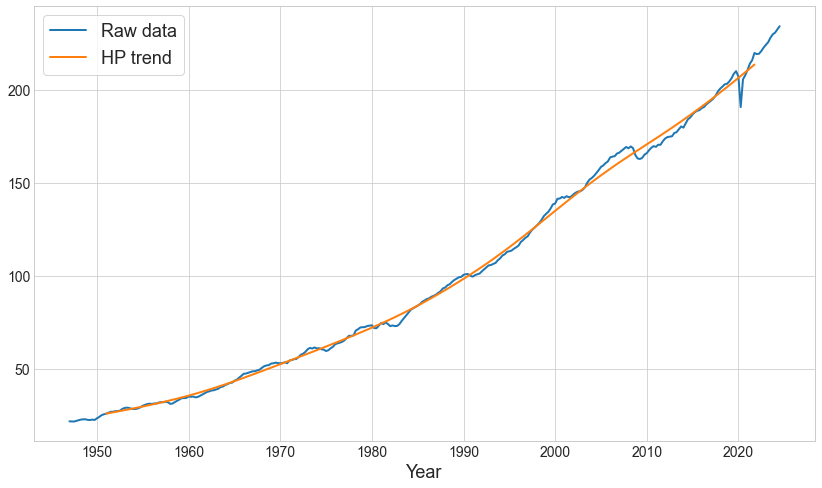

In [72]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.tick_params(labelsize=14)
ax.plot(data['y_qtr'],linewidth=2.0,label='Raw data')
ax.plot(qtrs,np.exp(data_selected['y_qtr_hp_trend']),linewidth=2.0,label='HP trend')
ax.legend(frameon=True, fontsize=18)
fig.savefig('../Figures/gdp_raw_trend.pdf')
plt.show()

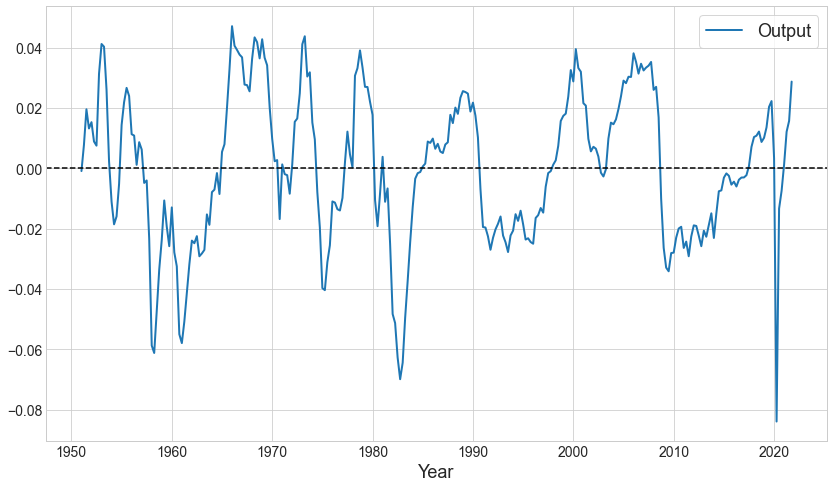

In [76]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.tick_params(labelsize=14)
ax.plot(qtrs,data_selected['y_qtr_hp_cycle'],linewidth=2.0,label='Output', ls='-')
ax.axhline(y=0.0, color='black', linestyle='--')
ax.legend(frameon=True, fontsize=18)
fig.savefig('../Figures/gdp_cycle.pdf')
plt.show()

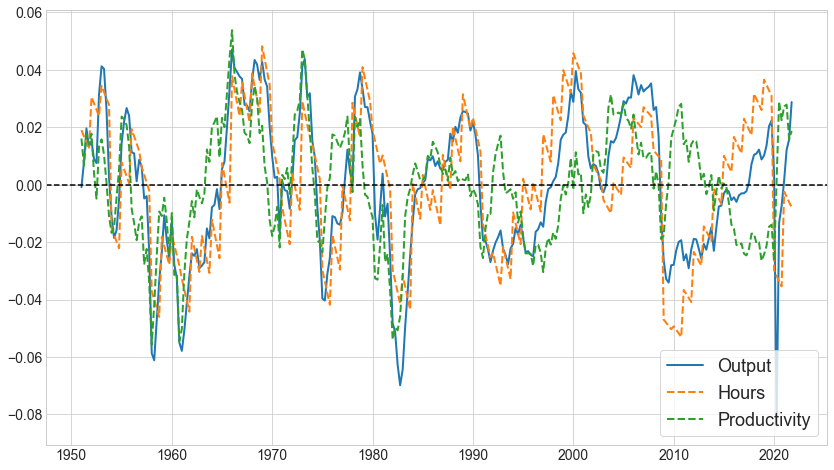

In [82]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.tick_params(labelsize=14)
ax.plot(qtrs,data_selected['y_qtr_hp_cycle'],linewidth=2.0,label='Output', ls='-')
ax.plot(qtrs,data_selected['hours_qtr_hp_cycle'],linewidth=2.0,label='Hours', ls='--')
ax.plot(qtrs,data_selected['a_qtr_hp_cycle'],linewidth=2.0,label='Productivity', ls='--')
ax.axhline(y=0.0, color='black', linestyle='--')
ax.legend(frameon=True, fontsize=18)
fig.savefig('../Figures/gdp_na_cycle.pdf')
plt.show()

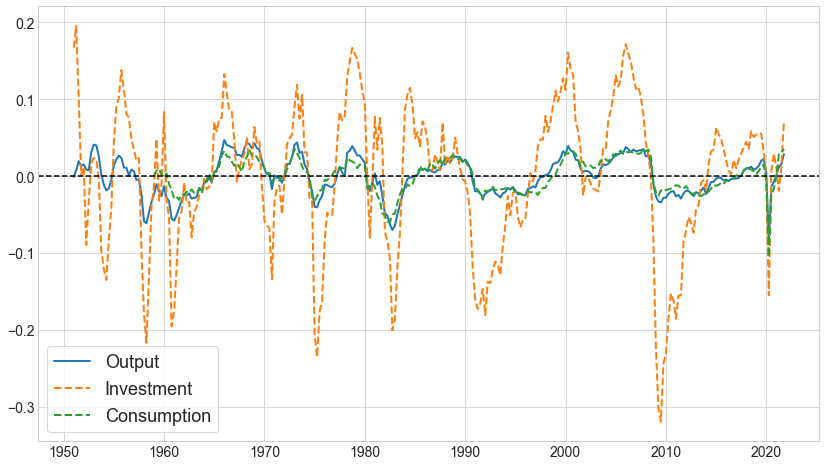

In [83]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.tick_params(labelsize=14)
ax.plot(qtrs,data_selected['y_qtr_hp_cycle'],linewidth=2.0,label='Output', ls='-')
ax.plot(qtrs,data_selected['i_qtr_hp_cycle'],linewidth=2.0,label='Investment', ls='--')
ax.plot(qtrs,data_selected['c_qtr_hp_cycle'],linewidth=2.0,label='Consumption', ls='--')
ax.axhline(y=0.0, color='black', linestyle='--')
ax.legend(frameon=True, fontsize=18)
fig.savefig('../Figures/gdp_ci_cycle.pdf')
plt.show()

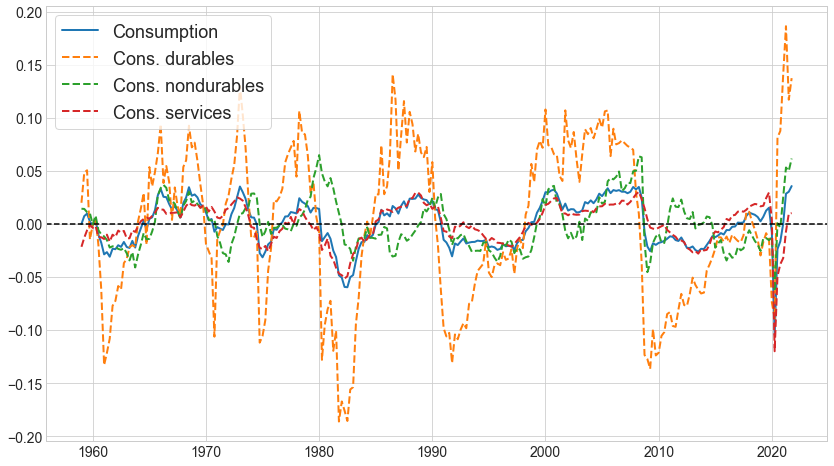

In [84]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.tick_params(labelsize=14)
ax.plot(qtrs,data_selected['c_qtr_hp_cycle'],linewidth=2.0,label='Consumption', ls='-')
ax.plot(qtrs,data_selected['c_dur_qtr_hp_cycle'],linewidth=2.0,label='Cons. durables', ls='--')
ax.plot(qtrs,data_selected['c_nondur_qtr_hp_cycle'],linewidth=2.0,label='Cons. nondurables', ls='--')
ax.plot(qtrs,data_selected['c_services_qtr_hp_cycle'],linewidth=2.0,label='Cons. services', ls='--')
ax.axhline(y=0.0, color='black', linestyle='--')
ax.legend(frameon=True, fontsize=18)
fig.savefig('../Figures/c_components_cycle.pdf')
plt.show()

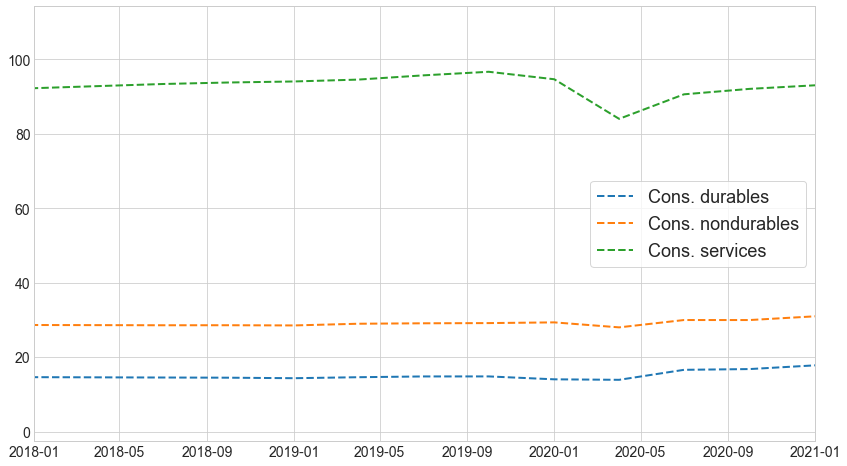

In [85]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.tick_params(labelsize=14)
ax.plot(data['c_dur_qtr'],linewidth=2.0,label='Cons. durables', ls='--')
ax.plot(data['c_nondur_qtr'],linewidth=2.0,label='Cons. nondurables', ls='--')
ax.plot(data['c_services_qtr'],linewidth=2.0,label='Cons. services', ls='--')
ax.legend(frameon=True, fontsize=18)
ax.set_xlim((np.datetime64('2018-01-01', 'Y'),np.datetime64('2021-01-01', 'Y')))
fig.savefig('../Figures/c_pandemic.pdf')
plt.show()